# Introduction

A study combining different task and rest states was performed over several subjects. The use of  fMRI, EEG or both as a combination is the is the differential point that makes this project stand out.

Summarising, the protocol of the article consists in ... ( RESUMEN DE TODOS LOS PUNTOS Y PROTOCOLOS DE NUESTROS ARTICULO )

## Imports

In [25]:
import mne
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
from matplotlib.pyplot import figure
from matplotlib import patches

import nilearn
from nilearn.datasets import fetch_spm_auditory
from nilearn import image
from nilearn import masking
import pandas as pd

from os.path import join as opj
from nibabel.testing import data_path
import json
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast, Normalize12
#tpm_img ='/home/ubuntu/Documents/MATLAB/spm12/tpm/TPM.nii' # normalization template

from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype import Workflow, Node
#from bids.layout import BIDSLayout
from nipype.algorithms.misc import Gunzip

import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat
import nibabel as nib
from nilearn import datasets

from dipy.io.image import load_nifti

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.utils.validation import column_or_1d
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

## Anatomical information

In [28]:
def Anatomical_representation (data_folder,subject_code):
     for i in  subject_code:
        print("Subject analyzed: {:.3f}".format(i))
        subject_folder='/sub-xp'
        String_contrinuation1='/anat/sub-xp'
        String_contrinuation2='_T1w.nii.gz'
        subject_codee=str(i)
        img = nib.load(mri_file)
        img_data = img.get_fdata()
        print("The shape of the anatomical data is: ")
        print(img.shape)
        
        fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
        
        ax[0].imshow(img_data[69, :, :].T, origin='lower', cmap='gray')
        ax[0].set_xlabel('Second dim voxel coords.', fontsize=12)
        ax[0].set_ylabel('Third dim voxel coords', fontsize=12)
        ax[0].set_title('First dimension, slice nr. 70', fontsize=15)

        ax[1].imshow(img_data[:, 249, 0:512:2].T, origin='lower', cmap='gray')
        ax[1].set_xlabel('First dim voxel coords.', fontsize=12)
        ax[1].set_ylabel('Third dim voxel coords', fontsize=12)
        ax[1].set_title('Second dimension, slice nr. 250', fontsize=15)

        ax[2].imshow(img_data[:, 0:512:2, 249].T, origin='lower', cmap='gray')
        ax[2].set_xlabel('First dim voxel coords.', fontsize=12)
        ax[2].set_ylabel('Second dim voxel coords', fontsize=12)
        ax[2].set_title('Third dimension, slice nr. 250', fontsize=15)

        fig.tight_layout()
        print("\n")
        
        return img_data

Subject analyzed: 101.000
The shape of the anatomical data is: 
(176, 512, 512)




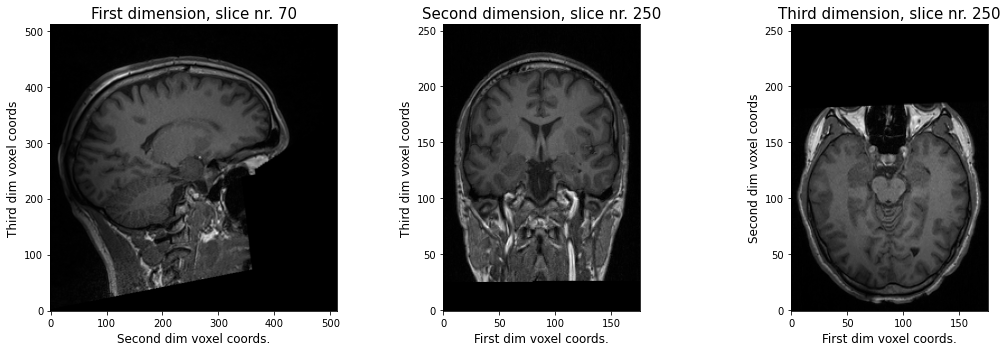

In [33]:
#Specify the particular path where the data that is wanted to be study is placed on your computer. 

#data_folder = '/Users/juliagarciacornet/Desktop/Q4/Neuroimatge/project'
data_folder = 'C:/Users/vctrf/Documents/Quatrimestre_2/Neuroimagen/proyecto Neuroimagen'

img_data=Anatomical_representation (data_folder,[101])

# img_data2=Anatomical_representation (data_folder,[106])
# img_data3=Anatomical_representation (data_folder,[109])

# a=img_data2-img_data3
# figure(figsize=(8, 6), dpi=80)
# mid_slice_x = a[60, :, :]
# plt.imshow(mid_slice_x.T, cmap='gray', origin='lower')
# plt.colorbar(label='Signal intensity')
# plt.show()
